In [1]:
import os
import sys
import time
import warnings
import argparse
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patch
warnings.filterwarnings("ignore")

from src.iter import infer_one_batch
from src.common_utils.draws import draw_volume_result
from src.common_utils.prints import print_info_message
from src.common_utils.dataset_building import split_processing_streams, extract_waiting_stacks

In [2]:
# Initialize parameters
parser = argparse.ArgumentParser(description = "CeNDeR pipeline")
# --------------------------------- Stack loading and Stage 1: Pre-processing ---------------------------------
parser.add_argument('--zrange', type = tuple, default = (0, 18))
parser.add_argument('--process-stack-root', type = str, default = '', help = '')
parser.add_argument('--load-preprocess-result-root', type = str, default = '')
parser.add_argument('--save-preprocess-result-root', type = str, default = '')
parser.add_argument('--name-reg', type = str, default = r"[iI]ma?ge?_?[sS]t(?:ac)?k_?\d+_dk?\d+.*[wW]\d+_?Dt\d{6}")
parser.add_argument('--preprocessing-pixel-threshold', type = float, default = 1.8)  # sum of mean + 3 * std of a volume
parser.add_argument('--preprocessing-mode', type = int, default = 3)
parser.add_argument('--only-preprocessing', action = "store_true")
parser.add_argument('--volume-window', type = int, default = 1, help = "number of processing volumes once")
parser.add_argument('--volume-start-idx', type = int, default = 0, help = "")
parser.add_argument('--error-filename', type = str, default = "AErrorStacks.txt", help = "")
parser.add_argument('--re-infer-error-stacks', action = "store_true", help = "")
parser.add_argument('--store-vis-result', type=int, default = 0, help = "")

# --------------------------------- Stage 2: Neuronal region detection ---------------------------------
# peak searching
parser.add_argument('--det-pixel-threshold', type = float, default = 1.8)  # the mean + 3 * std of a volume
# ANN
parser.add_argument('--det-fp16', type = int, default = 1)
parser.add_argument('--det-num-workers', type = int, default = 4)
parser.add_argument('--det-batch-size', type = int, default = 256)
parser.add_argument('--det-input-size', type = int, default = 41)
parser.add_argument('--det-model-load-path', type = str, default = 'models/released/cender_det_model_high_acc.ckpt')
parser.add_argument('--det-anchors-size', type = int, nargs = "+", default = [9])
parser.add_argument('--det-patches-size', type = int, nargs = "+", default = [15, 31, 41, 81])
# NMS
parser.add_argument('--det-nms-iou-threshold', type = float, default = 0.20)
parser.add_argument('--det-label-iou-threshold', type = float, default = 0.40)
parser.add_argument('--det-number-threshold', type = float, default = 100000)

# --------------------------------- Stage 3: 3D merging ---------------------------------
parser.add_argument('--merge-iou-threshold', type = float, default = 0.05)
parser.add_argument('--merge-span-threshold', type = int, default = 1)

# --------------------------------- Stage 4: Neuron recognition ---------------------------------
# neural points setting
parser.add_argument('--rec-fp16', action = "store_true")
parser.add_argument('--rec-other-class', action = "store_false")
parser.add_argument('--rec-worm-diagonal-line', type = float, default = 400.0)
parser.add_argument('--rec-z-scale', type = float, default = 5, help = "um/pixel")
# Embedding Feature
parser.add_argument('--rec-knn-k', type = int, default = 25)
# neural density feature
parser.add_argument('--rec-des-len', type = int, default = 20)
# neuron recognition
parser.add_argument('--rec-channel-base', type = int, default = 32)
parser.add_argument('--rec-group-base', type = int, default = 4)
parser.add_argument('--rec-len-embedding', type = int, default = 56)
# model setup
parser.add_argument('--rec-batch-size', default = 256, type = int)
parser.add_argument('--rec-model-load-path', type = str, default = "models/released/cender_rec_high_acc.ckpt")

# --------------------------------- Result saving ---------------------------------
parser.add_argument('--json-store-root', type = str, default = "")
parser.add_argument('--json-store-sub-root', type = str, default = "id")

args = parser.parse_args("")
# set data path
args.process_stack_root = "data/dataset/raw"
args.json_store_root = "data/dataset_result"
args.load_preprocess_result_root = "data/dataset/proofreading"
save_fig_root = os.path.join(args.json_store_root, "figs")

args.json_store_root = os.path.join(args.json_store_root, args.json_store_sub_root if args.json_store_sub_root else time.strftime('%m-%d'))
os.makedirs(args.json_store_root, exist_ok = True)
os.makedirs(save_fig_root, exist_ok = True)
error_file_path = os.path.join(args.json_store_root, args.error_filename)
print_info_message(args)

2022-08-08 14:14:25 - INFO    - Namespace(zrange=(0, 18), process_stack_root='data/dataset/raw', load_preprocess_result_root='data/dataset/proofreading', save_preprocess_result_root='', name_reg='[iI]ma?ge?_?[sS]t(?:ac)?k_?\\d+_dk?\\d+.*[wW]\\d+_?Dt\\d{6}', preprocessing_pixel_threshold=1.8, preprocessing_mode=3, only_preprocessing=False, volume_window=1, volume_start_idx=0, error_filename='AErrorStacks.txt', re_infer_error_stacks=False, store_vis_result=0, det_pixel_threshold=1.8, det_fp16=1, det_num_workers=4, det_batch_size=256, det_input_size=41, det_model_load_path='models/released/cender_det_model_high_acc.ckpt', det_anchors_size=[9], det_patches_size=[15, 31, 41, 81], det_nms_iou_threshold=0.2, det_label_iou_threshold=0.4, det_number_threshold=100000, merge_iou_threshold=0.05, merge_span_threshold=1, rec_fp16=False, rec_other_class=True, rec_worm_diagonal_line=400.0, rec_z_scale=5, rec_knn_k=25, rec_des_len=20, rec_channel_base=32, rec_group_base=4, rec_len_embedding=56, rec_bat

In [3]:
processing_stacks = extract_waiting_stacks(
        args.json_store_root, error_file_path, args.name_reg,
        re_infer_error = args.re_infer_error_stacks,
        paths = glob(os.path.join(args.process_stack_root, '*.mat')))[args.volume_start_idx:]

2022-08-08 14:14:25 - LOGS    - Processing stream: ['data/dataset/raw/ImgStk001_dk001_{w4_Dt210513230327rebuild}_{red_from566to1565}.mat']


S.4 recognition.ANN: 100%|██████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 62.35it/s]


2022-08-08 14:15:37 - INFO    - Results have been saved in data/dataset_result/id !


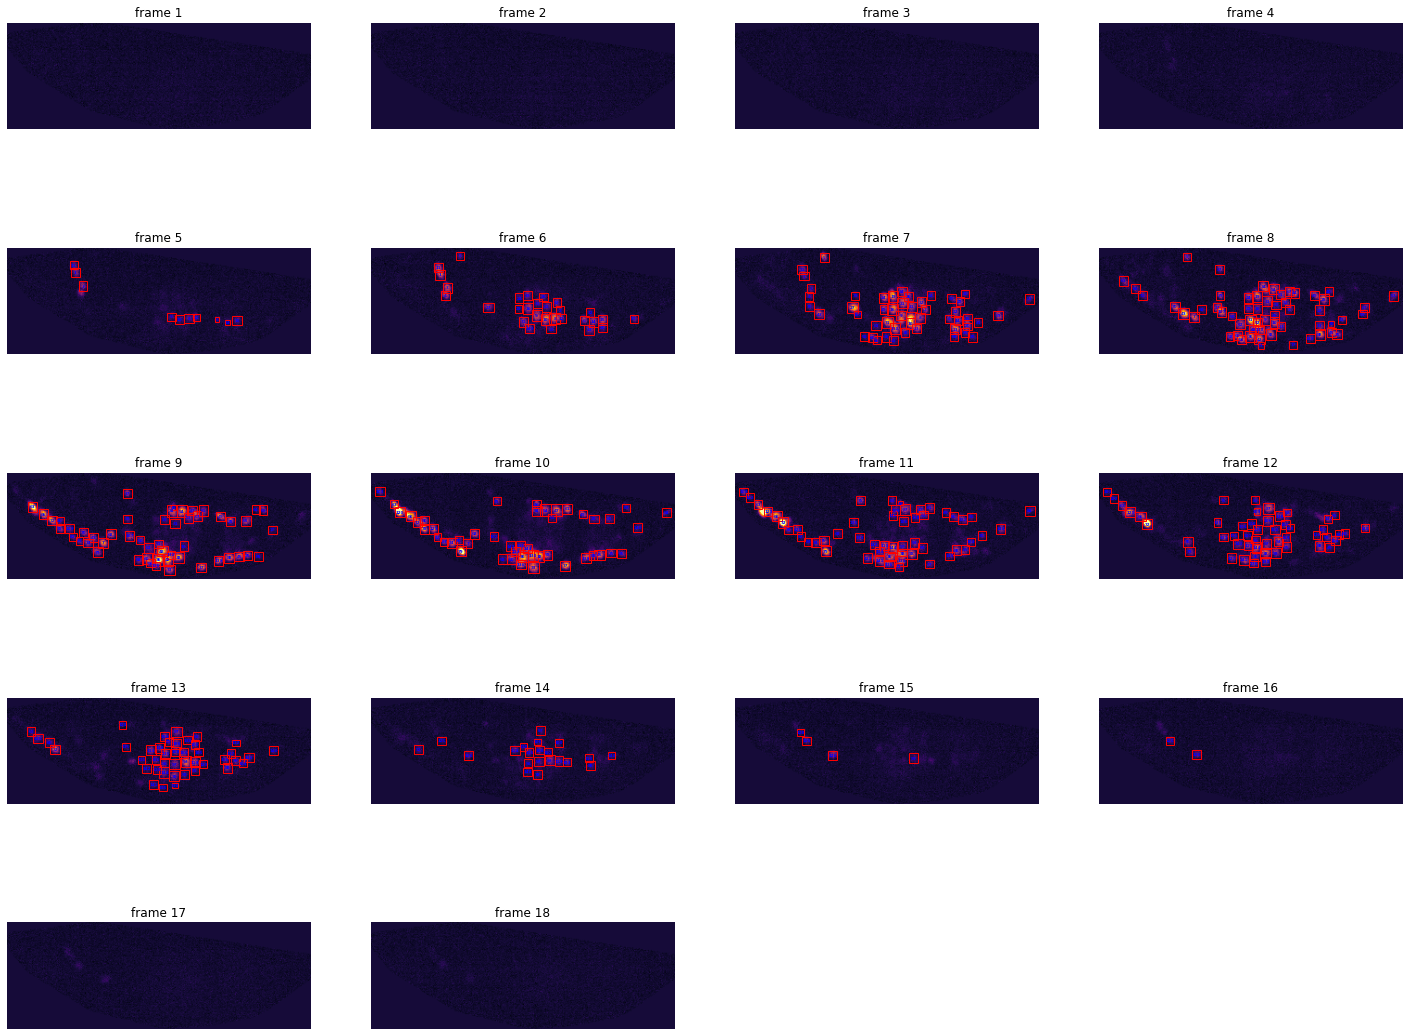

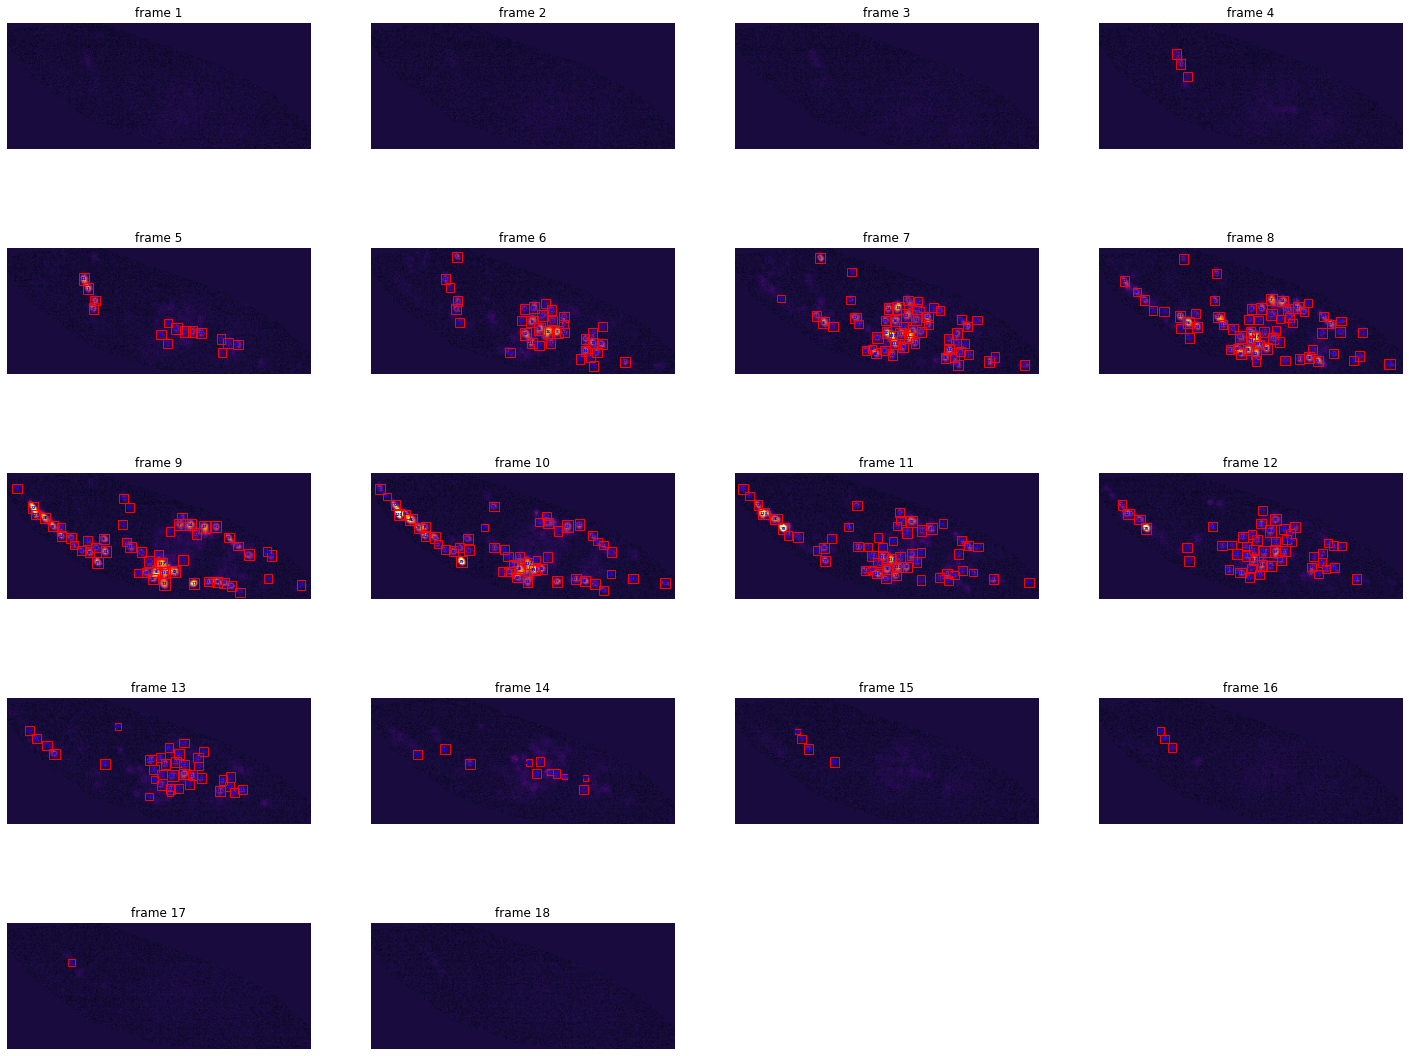

In [4]:
# example (recommend to use python command to run whole inference procedure,
#          jupyter notebook has many limits. see README.md)
for stream in split_processing_streams(processing_stacks, max_mats_one_stream = args.volume_window):
    rec_outputs, preprc_results = infer_one_batch(args, stream, error_file_path, is_saved = True)
    for name in np.random.choice(list(rec_outputs.keys()), 2, replace=False):
        draw_volume_result(rec_outputs[name], preprc_results[name], "", name, verbose = False)
    break

In [ ]:
# inference (it may lead to OOM problem for plt figures)
for stream in split_processing_streams(processing_stacks, max_mats_one_stream = args.volume_window):
    rec_outputs, preprc_results = infer_one_batch(args, stream, error_file_path, is_saved = True)
    for name in rec_outputs.keys():
        draw_volume_result(rec_outputs[name], preprc_results[name], save_fig_root, name, verbose = False)